This workflow is run on Savio cluster to compare the MPIPK strain to the Golor4 MGH1 strain reference using MPIPK RNAseq GSE129011. 
Some tools are already available on Savio.

In [2]:
!export MODULEPATH=${MODULEPATH}:/clusterfs/vector/home/groups/software/sl-7.x86_64/modfiles
!cd /global/scratch/users/hangxue/GSE129011

In [ ]:
import functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get fastq files of GSE129011 from ncbi 

In [8]:
!while read line; do wget https://trace.ncbi.nlm.nih.gov/Traces/sra-reads-be/fasta?acc=${line}; done < /global/scratch/users/hangxue/GSE129011/list_of_ids

--2024-07-24 15:03:03--  https://trace.ncbi.nlm.nih.gov/Traces/sra-reads-be/fasta?acc=SRR8800751
Resolving trace.ncbi.nlm.nih.gov (trace.ncbi.nlm.nih.gov)... 130.14.29.113, 2607:f220:41e:4290::113
Connecting to trace.ncbi.nlm.nih.gov (trace.ncbi.nlm.nih.gov)|130.14.29.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘fasta?acc=SRR8800751’

fasta?acc=SRR880075     [    <=>             ] 118.28M  1024KB/s    in 1m 57s  

2024-07-24 15:05:02 (1.01 MB/s) - ‘fasta?acc=SRR8800751’ saved [124023589]

--2024-07-24 15:05:02--  https://trace.ncbi.nlm.nih.gov/Traces/sra-reads-be/fasta?acc=SRR8800752
Resolving trace.ncbi.nlm.nih.gov (trace.ncbi.nlm.nih.gov)... 130.14.29.113, 2607:f220:41e:4290::113
Connecting to trace.ncbi.nlm.nih.gov (trace.ncbi.nlm.nih.gov)|130.14.29.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘fasta?acc=SRR8800752’

fasta?acc=SRR

# Download images and prepare files

In [ ]:
!singularity pull docker://trinityrnaseq/trinityrnaseq
!singularity pull docker://informationsea/minimap2
!singularity pull docker://ncbi/blast
!singularity pull docker://dceoy/samtools
!cat /global/scratch/users/hangxue/GSE129011/*.fastq.gz > /global/scratch/users/hangxue/GSE129011/Col_0_pathogen.fastq.gz

## The followings do not run successfully to the formatting issues in fastq.gz files (a space is added after each line). 

fastp -i /global/scratch/users/hangxue/GSE129011/SRR8800754.fastq.gz -o /global/scratch/users/hangxue/GSE129011/SRR8800754_fastp.fastq.gz

It seems the GSE129011 reads are already filtered and trimmed. 

The following salmon codes are able to run with the fastq.gz files. 

In [ ]:
!salmon index -t /global/scratch/users/hangxue/golor4/Golor4_GeneCatalog_transcripts_20191030.nt.fasta.gz -i /global/scratch/users/hangxue/golor4/Golor4_transcripts_index
!salmon quant -i /global/scratch/users/hangxue/golor4/Golor4_transcripts_index -l A -r /global/scratch/users/hangxue/Metatranscript/12531.2.262702.AGTCTCA-GTGAGAC.filter-RNA.fastq.gz --validateMappings -o /global/scratch/users/hangxue/Metatranscript/transcripts_quant
!salmon quant -i /global/scratch/users/hangxue/golor4/Golor4_transcripts_index -l A -r /global/scratch/users/hangxue/GSE129011/*fastq.gz --validateMappings -o /global/scratch/users/hangxue/GSE129011/transcripts_quant


In [10]:
salmon_quant = pd.read_csv('/global/scratch/users/hangxue/GSE129011/transcripts_quant_Col_0_pathogen_all_reps/quant.sf', sep = '\t')


In [11]:
salmon_quant

,Name,Length,EffectiveLength,TPM,NumReads
0,jgi|Golor4|1001102|CE993891_4688,1456,1206.0,12.358011,4.000
1,jgi|Golor4|100422|CE93211_6069,1996,1746.0,21.370446,10.014
2,jgi|Golor4|1004245|CE997034_6875,1049,799.0,18.653018,4.000
3,jgi|Golor4|1004507|CE997296_84,572,322.0,0.000000,0.000
4,jgi|Golor4|1004532|CE997321_16493,1851,1601.0,23.272581,10.000
...,...,...,...,...,...
12602,jgi|Golor4|99767|CE92556_3246,1293,1043.0,8.241620,2.307
12603,jgi|Golor4|999345|CE992134_2871,615,365.0,0.000000,0.000
12604,jgi|Golor4|999353|CE992142_15068,2585,2335.0,34.768434,21.789
12605,jgi|Golor4|99938|CE92727_5311,3455,3205.0,0.000000,0.000


# Use Trinity to assembly transcripts from GSE129011 and compare the assembled transcripts to Golor4

## Assemble transcripts

In [2]:
fastq_folder = "/global/scratch/users/hangxue/GSE129011"
library = "Col_0_pathogen.fasta"
seqtype = "fa"
functions.trinity_helper(fastq_folder, library, seqtype)

/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir


## Compare assembled transcripts to Golor4 using blast

Tried to use Golor4_GeneCatalog_transcripts_20191030.nt.fasta but blast does not like the JGI header with |. Used Golor4_AssemblyScaffolds.cds.fasta

In [ ]:
input_folder = "/global/scratch/users/hangxue/golor4"
reference = "Golor4_AssemblyScaffolds.cds.fasta"
functions.blast_makedb(input_folder, reference)

In [ ]:
input_folder = "/global/scratch/users/hangxue/GSE129011"
db = "Golor4_AssemblyScaffolds"
outdir ="/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir" 
query = "trinity.Trinity.fasta"
functions.blastn(input_folder, query, db, outdir)

/global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


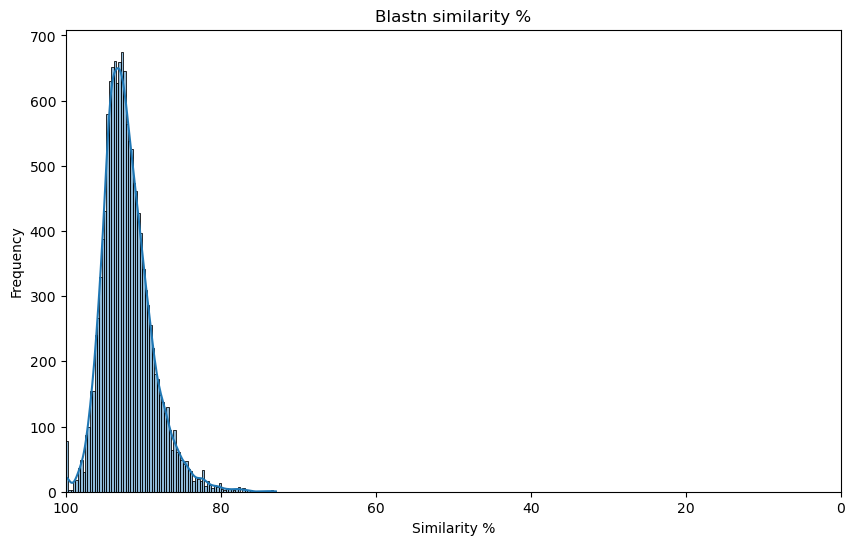

In [9]:
# Plot the distribution of the "score" column
plt.figure(figsize=(10, 6))
sns.histplot(input_file['score'], kde=True)
plt.title('Blastn similarity %')
plt.xlabel('Similarity %')
plt.ylabel('Frequency')
plt.xlim(100, 0)
plt.show()

## Map assembled transcripts to the reference using minimap2

### minimap 2

In [3]:
input_folder = "/global/scratch/users/hangxue/golor4"
fasta = "Golor4_AssemblyScaffolds.fasta"
functions.minimap2_index(input_folder, fasta)

[M::mm_idx_gen::4.910*1.54] collected minimizers
[M::mm_idx_gen::6.268*1.85] sorted minimizers
[M::main::8.780*1.61] loaded/built the index for 123 target sequence(s)
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 123
[M::mm_idx_stat::9.144*1.58] distinct minimizers: 14567558 (56.74% are singletons); average occurrences: 2.715; average spacing: 5.344
[M::main] Version: 2.17-r941
[M::main] CMD: /usr/local/bin/minimap2 -d /input/Golor4_AssemblyScaffolds.fasta.mmi /input/Golor4_AssemblyScaffolds.fasta
[M::main] Real time: 9.194 sec; CPU: 14.508 sec; Peak RSS: 1.163 GB


In [5]:
input_folder1 = "/global/scratch/users/hangxue/golor4"
input_folder2 = "/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir"
reference = "Golor4_AssemblyScaffolds.fasta.mmi"
trinity_assembly = "trinity.Trinity.fasta"
functions.minimap2_map(input_folder1, input_folder2, reference, trinity_assembly)

[M::main::1.597*0.96] loaded/built the index for 123 target sequence(s)
[M::mm_mapopt_update::1.919*0.97] mid_occ = 399
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 123
[M::mm_idx_stat::2.149*0.97] distinct minimizers: 14567558 (56.74% are singletons); average occurrences: 2.715; average spacing: 5.344
[M::worker_pipeline::5.199*1.89] mapped 68268 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: /usr/local/bin/minimap2 -a -o /outdir/trinity.Trinity.fasta_minimap.sam /input1/Golor4_AssemblyScaffolds.fasta.mmi /input2/trinity.Trinity.fasta
[M::main] Real time: 5.242 sec; CPU: 9.880 sec; Peak RSS: 0.958 GB


In [2]:
input_folder = "/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir/minimap2_outdir"
file = "trinity.Trinity.fasta_minimap.sam"
functions.samtools_sort(input_folder, file)

### Process coverage

In [3]:
input_folder = "/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir/minimap2_outdir"
file = "trinity.Trinity.fasta_minimap.sam.sort"
functions.samtools_cov(input_folder, file)

In [ ]:
input_folder = "/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir/minimap2_outdir"
file = "trinity.Trinity.fasta_minimap.sam.sort"
functions.samtools_dep(input_folder, file)

In [4]:
column_names = ['scaffold', 'position', 'coverage']
trinity_cov = pd.read_csv('/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir/minimap2_outdir/trinity.Trinity.fasta_minimap.sam.sort_dep.res', names=column_names, sep = '\t')


In [8]:
window_size = 500

df = trinity_cov
# Calculate the window for each scaffold
df['window'] = df['position'] // window_size
max_positions = df.groupby('scaffold')['position'].max()
# Calculate the mean coverage for each 1kb window for each scaffold
mean_coverage = df.groupby(['scaffold', 'window'])['coverage'].mean().reset_index()

print(mean_coverage)
mean_coverage["start"] = mean_coverage["window"]*window_size
mean_coverage["end"] = mean_coverage["start"]+window_size
# cgeck max position
mean_coverage['end'] = np.where(mean_coverage['end'] > mean_coverage['scaffold'].map(max_positions), mean_coverage['scaffold'].map(max_positions), mean_coverage['end'])
new_df = mean_coverage[['scaffold', 'start', 'end', 'coverage']]
new_df.to_csv(f"/global/scratch/users/hangxue/GSE129011/trinity_Col_0_pathogen.fasta_outdir/minimap2_outdir/trinity_minimap_cov_{window_size}bp.csv", index=False)

          scaffold  window  coverage
0       Scaffold_1     266  1.000000
1       Scaffold_1     267  1.000000
2       Scaffold_1     308  1.000000
3       Scaffold_1     309  0.908000
4       Scaffold_1     310  0.908000
...            ...     ...       ...
14149   Scaffold_9   28787  0.843496
14150  Scaffold_93      24  1.521851
14151  Scaffold_93      25  2.000000
14152  Scaffold_93      26  1.984000
14153  Scaffold_93      27  2.000000

[14154 rows x 3 columns]


### Plot coverage in circos

In [ ]:
import pycircos
import matplotlib.pyplot as plt
import collections

Garc    = pycircos.Garc
Gcircle = pycircos.Gcircle

#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open("/Users/hangxue/Documents/Wildermuth_Lab/Genome_Paper/Circos/top20_longest_scaffolds.fasta_stat.xls") as f:
    for line in f:
        line   = line.rstrip().split("\t") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(845,865), labelposition=80, label_visible=True)
        circle.add_garc(arc) 

In [ ]:
circle.set_garcs(-100,245) 

In [ ]:
for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(865,885), tickinterval=1000000, ticklabels=None) 

In [ ]:
values_all   = [] 
arcdata_dict = collections.defaultdict(dict)
threshold = 1

with open("/Users/hangxue/Documents/Wildermuth_Lab/Genome_Paper/Circos/trinity_minimap_cov_500bp.csv") as f:
    f.readline()
    for line in f:
        line  = line.rstrip().split(",")
        name  = line[0]     
        start = int(line[1])-1
        end   = int(line[2]) 
        width = end-start 
        if name not in arcdata_dict:
            arcdata_dict[name]["positions"] = []
            arcdata_dict[name]["widths"]    = [] 
            arcdata_dict[name]["values"]    = [] 
        arcdata_dict[name]["positions"].append(start) 
        arcdata_dict[name]["widths"].append(width)
        arcdata_dict[name]["values"].append(float(line[-1]))
        values_all.append(float(line[-1]))

vmin, vmax = min(values_all), min(values_all)+0.1
for key in arcdata_dict:
    try: 
        circle.heatmap(key, data=arcdata_dict[key]["values"], positions=arcdata_dict[key]["positions"], 
                    width=arcdata_dict[key]["widths"], raxis_range=[635,710], vmin=vmin, vmax=vmax, 
                    cmap=plt.cm.Reds)
    except KeyError:
        print(f"Skipping key {key} as it is not present in arcdata_dict.")
        continue

In [ ]:
circle.figure